# Q学習 推論


In [146]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

## Config
カリキュラム学習を0.5m区切りで行い4mの到達を目指す  
**QTableの保存名に注意すること！**

In [147]:
from torch import nn
# 定数の設定
ENV = 'RoombaEnv-v0'  # 使用する課題名
MAX_STEPS = 400  # 1試行のstep数
NUM_EPISODES = 11
NUM_DIZITIZED = 5
ONE_SIDE_OF_AREA = 4
LODING_QTABLE = 'q_table_cal1_test2_4_2.npz'

INI_DISTANCE = 1
# options_list = [[INI_DISTANCE,0],[INI_DISTANCE,0.1], [INI_DISTANCE,0.2],[INI_DISTANCE,0.3], [INI_DISTANCE,0.4], [INI_DISTANCE,0.5],
#                 [INI_DISTANCE,-0.1], [INI_DISTANCE,-0.2],[INI_DISTANCE,-0.3], [INI_DISTANCE,-0.4], [INI_DISTANCE,-0.5]]

# options_list = [[INI_DISTANCE,0],[INI_DISTANCE,0.2], [INI_DISTANCE,0.4],[INI_DISTANCE,0.6], [INI_DISTANCE,0.8], [INI_DISTANCE,1.0],[INI_DISTANCE,-0.2], [INI_DISTANCE,-0.4],[INI_DISTANCE,-0.6], [INI_DISTANCE,-0.8], [INI_DISTANCE,-1.0]]
options_list = [[INI_DISTANCE,0],[INI_DISTANCE,0.1], [INI_DISTANCE,0.3],[INI_DISTANCE,0.5], [INI_DISTANCE,0.6], [INI_DISTANCE,0.7],
                [INI_DISTANCE,-0.1], [INI_DISTANCE,-0.3],[INI_DISTANCE,-0.5], [INI_DISTANCE,-0.6], [INI_DISTANCE,-0.7]]

OUTPUT_VIDEO = False


anguler_variation = 0.246 # Roombaのモデル (rad)


# 記録用
memory_loss = []
update_count = []
memory_step = []
sum_reward = []
memory_reward_mean = []
episode_count = []
done_counts = []
memory_distance = []
memory_theta = []


## 準備

In [148]:
import os
import shutil

target_dir = 'Roomba_move_img'

shutil.rmtree(target_dir)
os.mkdir(target_dir)

In [149]:
# namedtupleを生成
from collections import namedtuple
 
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

## Roomba simulator

In [150]:
import numpy as np
import random
import cv2

import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class RoombaSimulator:
    def __init__(self):
        self.world_pos_position = [0, 0]  # 初期位置 [x, y]
        self.world_pos_position_pre = [0, 0]
        self.ball_pos_position = [0, 0]  # ボールの初期位置 [x, y]
        self.odometry_position = [0, 0]  # オドメトリ
        self.odometry_position_pre = [0, 0]

        self.world_orientation = 0   # 初期姿勢 (rad)
        self.orientation = 0

        self.left_wheel_rotation = 0  # 左車輪の回転角度 (rad)
        self.right_wheel_rotation = 0  # 右車輪の回転角度 (rad)

        self.wheel_radius = 0.072  # 車輪の半径 (50mmをmに変換)
        self.tread = 0.235  # トレッド
        self.size = 0.165 # Roombaの半径

        self.one_side_of_area = ONE_SIDE_OF_AREA #行動環境の一辺の長さ

        self.delta_x = 0
        self.delta_y = 0
        self.delta_theta = 0

        self.vertex1 = (0,0)
        self.vertex2 = (0,0)
        self.vertex3 = (0,0)
        self.vertex4 = (0,0)

        self.animation = []
        self.out_img = []

        self.count = 0

        self.fig = plt.figure(figsize=(10,10))

    def random_pos(self):
        self.ball_pos_position = [0, 0]
        self.world_pos_position = [0, 0]

        while self.world_pos_position[0]-self.ball_pos_position[0]  <= 0.1 and self.world_pos_position[1]-self.ball_pos_position[1] <= 0.1:

            self.world_pos_position = [
                random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2),
                random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2)]  # 初期位置 [x, y]
            # self.ball_pos_position = [random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2), random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2)]  # ボールの初期位置 [x, y]
            self.world_orientation = random.uniform(-3.14, 3.14)

    def init_pos(self,episode_count):
        self.ball_pos_position = [1, 0]
        self.world_pos_position = [0, 0]
        self.world_orientation = 0

        # options_list = [[0.5,0],
        #                 [0.5,0.05], [0.5,0.1],[0.5,0.15], [0.5,0.2], [0.5,0.25],
                #                 [0.5,-0.05], [0.5,-0.1],[0.5,-0.15], [0.5,-0.2], [0.5,-0.25]]
        # options_list = [[1,0],[1,0.1], [1,0.2],[1,0.3], [1,0.4], [1,0.5],[1,-0.1], [1,-0.2],[1,-0.3], [1,-0.4], [1,-0.5]]
        # options_list = [[0.5,0.2], [0.5,0.25], [0.5,-0.2], [0.5,-0.25]]

        self.ball_pos_position = options_list[episode_count]
        # self.world_pos_position = [0,0]


    def odometry_update(self, left_wheel_rotation_delta, right_wheel_rotation_delta):
        # 車輪の回転角度を更新
        self.left_wheel_rotation += left_wheel_rotation_delta
        self.right_wheel_rotation += right_wheel_rotation_delta

        # Roombaの位置と姿勢を更新
        left_wheel_distance = left_wheel_rotation_delta * self.wheel_radius
        right_wheel_distance = right_wheel_rotation_delta * self.wheel_radius

        delta_distance = (left_wheel_distance + right_wheel_distance) / 2
        self.delta_theta = (right_wheel_distance - left_wheel_distance) / self.tread

        self.delta_x = delta_distance * np.cos(self.orientation)
        self.delta_y = delta_distance * np.sin(self.orientation)

        self.odometry_position[0] += self.delta_x
        self.odometry_position[1] += self.delta_y
        self.orientation += self.delta_theta


    def world_pos_update(self):
        # Roombaのワールド座標系での移動を計算
        world_delta_x = np.cos(self.world_orientation) * self.delta_x - np.sin(self.world_orientation) * self.delta_y
        world_delta_y = np.sin(self.world_orientation) * self.delta_x + np.cos(self.world_orientation) * self.delta_y

        # Roombaのワールド座標系での位置を更新
        self.world_pos_position[0] += world_delta_x
        self.world_pos_position[1] += world_delta_y

        #壁に突っ込んだら，座標を更新しない．
        # if self.world_pos_position[0]-self.size > -0.5 and self.world_pos_position[0] + self.size <  4.5 and\
        #    abs(self.world_pos_position[1])+self.size < 4:

        if abs(self.world_pos_position[0])+self.size < self.one_side_of_area/2 and \
            abs(self.world_pos_position[1])+self.size < self.one_side_of_area/2:

            self.world_pos_position_pre[0] = self.world_pos_position[0]
            self.world_pos_position_pre[1] = self.world_pos_position[1]

            self.odometry_position_pre[0] = self.odometry_position[0]
            self.odometry_position_pre[1] = self.odometry_position[1]

        else:
            self.world_pos_position[0] = self.world_pos_position_pre[0]
            self.world_pos_position[1] = self.world_pos_position_pre[1]

            self.odometry_position[0] = self.odometry_position_pre[0]
            self.odometry_position[1] = self.odometry_position_pre[1]

        # Roombaのワールド座標系での回転を更新
        self.world_orientation += self.delta_theta

        '''ホモグラフィ変換された視野'''
        trapezoid_length_Top_side = 0  # 台形の下辺の長さ
        trapezoid_length_Bottom_side = 5.2  # 台形の下辺の長さ
        trapezoid_height = 3  # 台形の高さ

        top_side_offset_Xcom = trapezoid_length_Top_side/2 * np.cos(self.world_orientation + np.pi/2)
        top_side_offset_Ycom = trapezoid_length_Top_side/2 * np.sin(self.world_orientation + np.pi/2)
        bottom_side_offset_Xcom = trapezoid_length_Bottom_side/2 * np.cos(self.world_orientation + np.pi/2)
        bottom_side_offset_Ycom = trapezoid_length_Bottom_side/2 * np.sin(self.world_orientation + np.pi/2)

        height_offset_Xcom = trapezoid_height * np.cos(self.world_orientation)
        height_offset_Ycom = trapezoid_height * np.sin(self.world_orientation)

        size_offset_Xcom = self.size * np.cos(self.world_orientation)
        size_offset_Ycom = self.size * np.sin(self.world_orientation)

        # 台形の頂点座標
        # 左端
        self.vertex1 = (self.world_pos_position[0] -  top_side_offset_Xcom + size_offset_Xcom,
                   self.world_pos_position[1] -  top_side_offset_Ycom + size_offset_Ycom)

        # 左上
        self.vertex4 = ((self.world_pos_position[0] -  bottom_side_offset_Xcom) + height_offset_Xcom,
                   (self.world_pos_position[1] -  bottom_side_offset_Ycom) + height_offset_Ycom)

        # 右端
        self.vertex2 = (self.world_pos_position[0] +  top_side_offset_Xcom + size_offset_Xcom,
                   self.world_pos_position[1] +  top_side_offset_Ycom + size_offset_Ycom)

        # 右上
        self.vertex3 = ((self.world_pos_position[0] +  bottom_side_offset_Xcom) + height_offset_Xcom,
                   (self.world_pos_position[1] +  bottom_side_offset_Ycom) + height_offset_Ycom)

    def plot(self):
        # Roombaの位置と姿勢をMatplotlibでプロット
        self.count += 1

        fig, ax = plt.subplots(figsize=(10.0, 10.0))
        ax.clear()
        plt.clf()

        # 青い点でRoombaの中心を表現
        plt.plot(self.world_pos_position[0], self.world_pos_position[1], 'bo')

        # 赤い点でballの中心を表現
        plt.plot(self.ball_pos_position[0], self.ball_pos_position[1], 'ro')

        # 半径0.165の円をプロット
        circle = plt.Circle((self.world_pos_position[0], self.world_pos_position[1]), 0.165, color='cyan', fill=False)
        plt.gca().add_patch(circle)

        # 赤い矢印で姿勢を表現
        line_length = 0.3
        line_dx = line_length * np.cos(self.world_orientation)
        line_dy = line_length * np.sin(self.world_orientation) #:.2f .format(self.world_pos_position[0])

        plt.arrow(self.world_pos_position[0], self.world_pos_position[1], line_dx, line_dy, color='red', width=0.02)

        # 視野を描画
        trapezoid = plt.Polygon([self.vertex1, self.vertex2,self.vertex3,self.vertex4], fill=False, edgecolor='green')
        plt.gca().add_patch(trapezoid)

        # グラフを正方形にし、目盛りを1ずつ増加
        plt.axis('equal')
        plt.xticks(np.arange(-5, 5, 0.5))
        plt.yticks(np.arange(-5, 5, 0.5))

        plt.title("Roomba Simulator")
        plt.grid(True)
        # plt.show()
        self.fig = fig

        '''動画作成'''
        self.fig.canvas.draw()
        image_array = np.array(self.fig.canvas.renderer.buffer_rgba())
        im = cv2.cvtColor(image_array, cv2.COLOR_RGBA2BGR)
        # print(type(im))
        file_name = f"Roomba_move_img/image_{self.count + 1:03d}.png"
        cv2.imwrite(file_name, im)
        # self.video.write(im)

    def is_inside_trapezoid(self):
        def cross_product(ax, ay, bx, by, cx, cy):
            return (bx - ax) * (cy - ay) - (by - ay) * (cx - ax)

        # 連続する頂点の各ペアについて外積を計算する．
        cross_product_ver1to2 = cross_product(self.vertex1[0], self.vertex1[1], self.vertex2[0], self.vertex2[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver2to3 = cross_product(self.vertex2[0], self.vertex2[1], self.vertex3[0], self.vertex3[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver3to4 = cross_product(self.vertex3[0], self.vertex3[1], self.vertex4[0], self.vertex4[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver4to1 = cross_product(self.vertex4[0], self.vertex4[1], self.vertex1[0], self.vertex1[1], self.ball_pos_position[0], self.ball_pos_position[1])

        # ballが台形内に入っているかを判定する．
        if (cross_product_ver1to2 >= 0 and cross_product_ver2to3 >= 0 and
                cross_product_ver3to4 >= 0 and cross_product_ver4to1 >= 0) or \
        (cross_product_ver1to2 <= 0 and cross_product_ver2to3 <= 0 and
                cross_product_ver3to4 <= 0 and cross_product_ver4to1 <= 0):
            return True
        else:
            return False

    def get_world_pos_ori(self):
        return self.world_pos_position[0],self.world_pos_position[1],self.world_orientation

    def get_ball_pos(self):
        return self.ball_pos_position[0], self.ball_pos_position[1]
        # if self.is_inside_trapezoid():
        #     return self.ball_pos_position[0], self.ball_pos_position[1]
        # else:
        #     return [-1,-1]

    def touch_ball(self):


        if np.sqrt((self.world_pos_position[0]-self.ball_pos_position[0])**2
                   +(self.world_pos_position[1]-self.ball_pos_position[1])**2) <= 0.165:
            return True
        else:
            return False

## Roomba environment
参考：https://developers.agirobots.com/jp/openai-gym-custom-env/

In [151]:
import torch
import gymnasium as gym
from gymnasium import spaces
import math

class RoombaEnv_Q(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(RoombaEnv_Q, self).__init__()
        self.roomba_simulator = RoombaSimulator()
        pos_limit_x,pos_limit_y = [self.roomba_simulator.one_side_of_area / 2] * 2

        self.action_space = gym.spaces.Discrete(3)       # エージェントが取りうる行動空間を定義

        self.pre_distance = 0
        self.ini_distance = 0
        self.final_distance = 0
        self.pre_theta = 0
        self.episode_count = 0
        self.step_count = 0

        self.ini_x = 0
        self.ini_y = 0

        self.observation_space = gym.spaces.Box(
        low=np.array([0, 0], dtype=np.float32),
        high=np.array([1, 1], dtype=np.float32),
        shape=(2,),)

        # self.reward_range = (0,1)       # 報酬の範囲[最小値と最大値]を定義


    def cal_normalized_distance_and_theta(self,roomba_x,roomba_y,ball_x,ball_y):
        # 距離を0から1に射影する
        self.final_distance = np.sqrt((roomba_x-ball_x)**2+(roomba_y-ball_y)**2)
        normalized_distance = self.final_distance/self.ini_distance

        # 角度を度に変換
        angle = math.atan2((ball_y-roomba_y),(ball_x - roomba_x))
        angle_degrees = math.degrees(angle)

        # -90度から90度の範囲に収める
        if angle_degrees < -90:
            angle_degrees += 180
        elif angle_degrees > 90:
            angle_degrees -= 180

        # 角度を0から1に射影する
        normalized_angle = (angle_degrees + 90) / 180

        if not self.roomba_simulator.is_inside_trapezoid():
            normalized_distance = -1
            normalized_angle = -1

        return normalized_distance,normalized_angle


    def reset(self):
        self.roomba_simulator.init_pos(self.episode_count)
        roomba_x,roomba_y,roomba_ori = self.roomba_simulator.get_world_pos_ori()
        ball_x,ball_y = self.roomba_simulator.get_ball_pos()
        self.ini_x = ball_x
        self.ini_y = ball_y

        self.ini_distance = np.sqrt((roomba_x-ball_x)**2+(roomba_y-ball_y)**2)
        distance,theta = self.cal_normalized_distance_and_theta(roomba_x,roomba_y,ball_x,ball_y)
        self.pre_distance = self.ini_distance
        self.episode_count += 1
        self.step_count = 0

        obs = np.array([distance,theta])

        return obs

    def ctrl(self,action):
        if action == 0:
            left_wheel_rotation_delta = anguler_variation
            right_wheel_rotation_delta = anguler_variation
        elif action == 1:
            left_wheel_rotation_delta = anguler_variation/2
            right_wheel_rotation_delta = anguler_variation
        elif action == 2:
            left_wheel_rotation_delta = anguler_variation
            right_wheel_rotation_delta = anguler_variation/2

        return left_wheel_rotation_delta,right_wheel_rotation_delta



    def step(self, action):
        left_wheel_rotation_delta,right_wheel_rotation_delta = self.ctrl(action)
        self.roomba_simulator.odometry_update(left_wheel_rotation_delta, right_wheel_rotation_delta)
        self.roomba_simulator.world_pos_update()
        roomba_x,roomba_y,roomba_ori = self.roomba_simulator.get_world_pos_ori()
        ball_x,ball_y = self.roomba_simulator.get_ball_pos()

        distance,theta = self.cal_normalized_distance_and_theta(roomba_x,roomba_y,ball_x,ball_y)

        reward = 0

        obs = np.array([distance,theta])

        if self.roomba_simulator.touch_ball():
            done = True
            reward = 1
        else:
            done = False

        info = {'distance':self.final_distance,'theta':theta,'ini_x':self.ini_x,'ini_y':self.ini_y}
        self.step_count += 1

        return obs, reward, done, info

    def make_anime(self):
        self.roomba_simulator.plot()


    # def close(self):

    # def seed(self, seed=None):


In [152]:
import gymnasium as gym
gym.envs.registration.register(id='RoombaEnv-v0',entry_point=RoombaEnv_Q)

c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment RoombaEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Q-Inference

In [153]:
from collections import defaultdict
import numpy

class Q_Inference:
    def __init__(self):
        data = np.load(LODING_QTABLE)
        self.q_table = data['q_table']

    def decide_action(self, state):
        action = np.argmax(self.q_table[state])
        return action

## Environment class

In [154]:
import os
import cv2
import shutil
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class Environment:
    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定, render_mode="human"
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n
        # 環境内で行動するAgentを生成
        self.q_agent = Q_Inference()
        self.reward_mean = np.zeros(10)  # 10試行分の報酬を格納し、平均報酬を求める．

        # 動画の記録
        self.fig = plt.figure()
        self.movie = []

        self.rewards = 0
        self.reward_mean_pre = 0
        self.updata_episode = 0
        self.num_dizitized = NUM_DIZITIZED

        self.video_index = 0
        self.done_count = 0

    def reset_img(self):
        target_dir = 'Roomba_move_img'
        shutil.rmtree(target_dir)
        os.mkdir(target_dir)

    def images_2_video(self,input_dir, output_dir, fps=30):
        images = []

        # 画像を読み込む
        for filename in sorted(os.listdir(input_dir)):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                img_path = os.path.join(input_dir, filename)
                img = cv2.imread(img_path)
                images.append(img)

        # 画像のサイズを取得
        height, width, layers = images[0].shape

        # 動画の設定
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 出力動画のコーデック

        # 連番の動画名を生成
        output_path = os.path.join(output_dir, f"output_video_{self.video_index}.mp4")

        # VideoWriterを作成
        video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # 画像を動画に書き込む
        for img in images:
            video.write(img)

        # リソースを解放
        video.release()

        print(f"動画が保存されました: {output_path}")

    # 各値を離散値に変換
    def bins(self, clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]


    def digitize_state(self, observation):
        distance,angle = observation
        if distance == -1 and angle == -1:
            return 25
        digitized = [
            np.digitize(distance, bins=self.bins(0, 1, self.num_dizitized)),
            np.digitize(angle, bins=self.bins(0, 1, self.num_dizitized))
        ]

        return sum([x * (self.num_dizitized**i) for i, x in enumerate(digitized)])


    def run(self):
        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            state = self.digitize_state(observation)
            done_counts.append(self.done_count)
            self.rewards = 0
            self.done_count = 0

            for i in range(100):
                for step in range(MAX_STEPS):
                    action = self.q_agent.decide_action(state)  # 行動を求める
                    observation_next, reward, done, info = self.env.step(action)
                    state_next = self.digitize_state(observation_next)
                    if OUTPUT_VIDEO:
                        self.env.make_anime()
                    state = state_next
                    self.rewards += reward

                    if done or step == MAX_STEPS -1:

                        self.reward_mean = np.hstack((self.reward_mean[1:], self.rewards))
                        print('%d Episode: Finished after %d steps : Episode rewards = %.3lf  :10Average = %.3lf  :final_distance = %.3lf : ini_x = %.3lf :  ini_y = %.3lf '
                            % (episode, step + 1,self.rewards, self.reward_mean.mean(), info['distance'],info['ini_x'],info['ini_y']))

                        if done:
                            self.done_count += 1

                        episode_count.append(episode + 1)
                        memory_reward_mean.append(self.reward_mean.mean())
                        sum_reward.append(self.rewards)
                        memory_step.append(step+1)
                        memory_distance.append(info['distance'])
                        memory_theta.append(info['theta'])

                        if OUTPUT_VIDEO:
                            self.images_2_video('./Roomba_move_img','./movies')
                        self.reset_img()

                        self.video_index += 1
                        break

# main

In [155]:
# main
roomba_env = Environment()
roomba_env.run()
# roomba_env.inference()

c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:189: UserWarning: WARN: The resu

0 Episode: Finished after 74 steps : Episode rewards = 1.000  :10Average = 0.100  :final_distance = 0.165 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 1 steps : Episode rewards = 2.000  :10Average = 0.300  :final_distance = 0.154 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 1 steps : Episode rewards = 3.000  :10Average = 0.600  :final_distance = 0.144 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 1 steps : Episode rewards = 4.000  :10Average = 1.000  :final_distance = 0.136 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 1 steps : Episode rewards = 5.000  :10Average = 1.500  :final_distance = 0.129 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 1 steps : Episode rewards = 6.000  :10Average = 2.100  :final_distance = 0.124 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 1 steps : Episode rewards = 7.000  :10Average = 2.800  :final_distance = 0.121 : ini_x = 1.000 :  ini_y = 0.000 
0 Episode: Finished after 

1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 10.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: Finished after 400 steps : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 2.442 : ini_x = 1.000 :  ini_y = 0.100 
1 Episode: F

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Plot

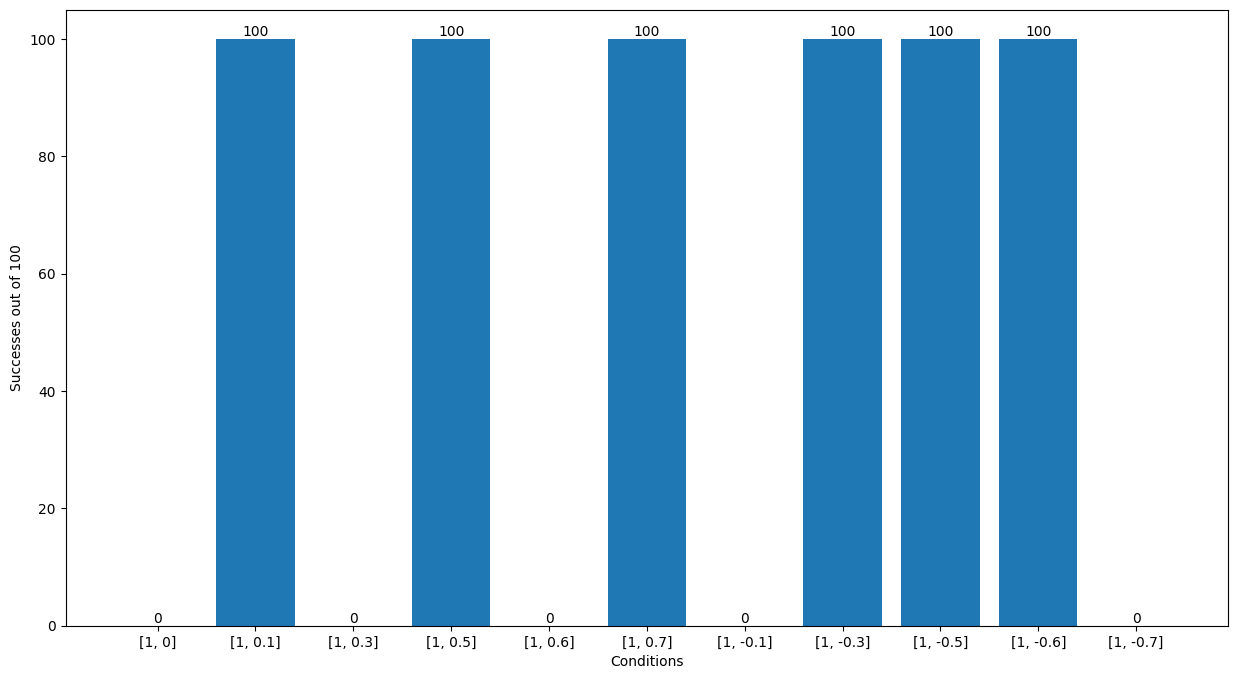

In [157]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
height = done_counts
labels = options_list

fig, ax = plt.subplots(figsize=(15, 8))

ax.set_ylabel('Successes out of 100')
ax.set_xlabel('Conditions')

bars = ax.bar(x, height)
plt.xticks(x, labels)

# バーの上に値を追加
for bar, value in zip(bars, height):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value),
            ha='center', va='bottom')

plt.show()
